In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
path = "/content/drive/MyDrive/"

## Task:
add one more class 4,5,6 as neutral comments, retrain and evaluate the model

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Dataset

In [65]:
df = pd.read_csv(path+'texts_train.txt', sep="\t", encoding='UTF-8',header=0)
df['grade'] = pd.read_csv(path+'scores_train.txt', sep="\t", encoding='UTF-8',header=0)
df.columns = ['comment', 'grade']
print(df.head())

                                             comment  grade
0  думал, что будет лучше идея очень интересна - ...      7
1  с творчеством Головачева я познакомился посред...     10
2  то-то я и в большое неудовольствие прочитал "А...      5
3  как мне показалось местами сильно смахивает на...      6
4  от первой части книги просто оторваться не мог...      9


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  19999 non-null  object
 1   grade    19999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [67]:
unique_grades = np.sort(df['grade'].unique())
print('all unique grades: ', unique_grades)

all unique grades:  [ 1  2  3  4  5  6  7  8  9 10]


## Distribution of grades

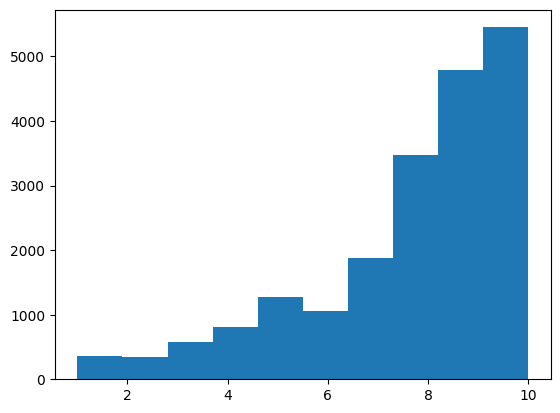

In [68]:
plt.hist(df['grade'], bins=10)
plt.show()

## Binary encoding

In [69]:
def encode_grades(grade: int) -> list[int]:
    if grade in range(1, 4):
        return [1, 0, 0], "bad"
    if grade in range(4, 7):
        return [0, 1, 0], "neutral"
    if grade in range(7, 11):
        return [0, 0, 1], "good"

In [70]:
df[["encoded_grade", "label"]] = df["grade"].apply(encode_grades).apply(pd.Series)

In [71]:
df.head()

,comment,grade,encoded_grade,label
0,"думал, что будет лучше идея очень интересна - ...",7,"[0, 0, 1]",good
1,с творчеством Головачева я познакомился посред...,10,"[0, 0, 1]",good
2,"то-то я и в большое неудовольствие прочитал ""А...",5,"[0, 1, 0]",neutral
3,как мне показалось местами сильно смахивает на...,6,"[0, 1, 0]",neutral
4,от первой части книги просто оторваться не мог...,9,"[0, 0, 1]",good


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   comment        19999 non-null  object
 1   grade          19999 non-null  int64 
 2   encoded_grade  19999 non-null  object
 3   label          19999 non-null  object
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


## Balancing the dataset

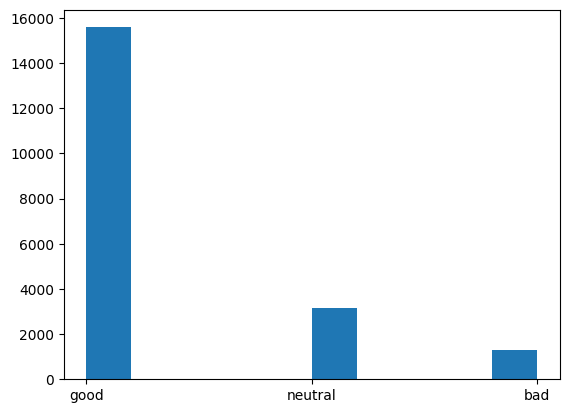

In [73]:
plt.hist(df['label'])
plt.show()

In [74]:
unique_grades = df["label"].unique()
min_sample = df['label'].value_counts().min()
print('min_sample: ', min_sample)

min_sample:  1286


In [75]:
df_balanced = pd.DataFrame()

for label in df['label'].unique():
    df_class = df[df['label'] == label]
    df_class_downsampled = resample(
        df_class,
        replace=False,
        n_samples=min_sample,
        random_state=123
    )
    df_balanced = pd.concat([df_balanced, df_class_downsampled])

In [76]:
df_balanced.head()

,comment,grade,encoded_grade,label
3651,"Мне очень понравилось это произведение, как вп...",10,"[0, 0, 1]",good
8398,Главный плюс этой книги - рассказ о проблеме р...,8,"[0, 0, 1]",good
8372,"В принципе гениальное произведение, но почему-...",9,"[0, 0, 1]",good
19106,"Очень ржачная комедия, но только первые две тр...",9,"[0, 0, 1]",good
939,Наша бессмертная классика,9,"[0, 0, 1]",good


In [77]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3858 entries, 3651 to 17860
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   comment        3858 non-null   object
 1   grade          3858 non-null   int64 
 2   encoded_grade  3858 non-null   object
 3   label          3858 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.7+ KB


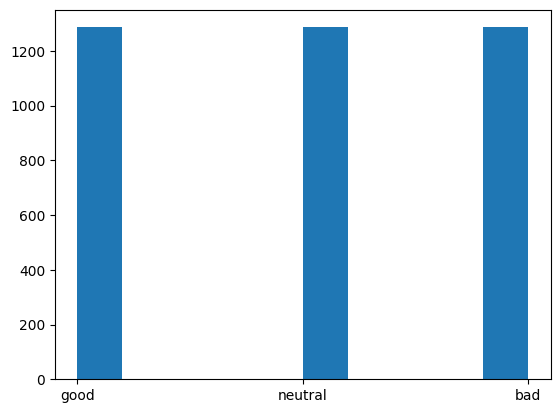

In [78]:
plt.hist(df_balanced['label'])
plt.show()

## Preprocessing

In [79]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [80]:
comments = df_balanced['comment'].values

In [81]:
def preprocessing(text: str) -> list[str]:
    text = text.lower()
    text = ''.join([c for c in text if c not in punctuation])
    text = text.split(' ')
    return text

In [82]:
tokenized_corpus = [preprocessing(comment) for comment in comments]

In [83]:
tokenized_corpus[:5]

[['мне',
  'очень',
  'понравилось',
  'это',
  'произведение',
  'как',
  'впрочем',
  'и',
  'все',
  'у',
  'татьяны',
  'устиновой',
  'оно',
  'немного',
  'не',
  'похоже',
  'на',
  'другие',
  'ее',
  'романы',
  'но',
  'именно',
  'этим',
  'и',
  'интересно',
  'захватывающий',
  'сюжет',
  'все',
  'детали',
  'взвешены',
  'и',
  'продуманы',
  'до',
  'мелочей',
  'любовная',
  'линия',
  'романтична',
  'и',
  'ненавязчива',
  'и',
  'все',
  'хорошо',
  'заканчивается',
  'почитаешь',
  'такой',
  'роман',
  'и',
  'жить',
  'становится',
  'легче',
  'и',
  'веселей',
  'потому',
  'что',
  'у',
  'устиновой',
  'очень',
  'тонкий',
  'приятный',
  'юмор',
  'смешной',
  'если',
  'так',
  'можно',
  'выразиться',
  'и',
  'добро',
  'побеждает',
  'зло',
  'и',
  'от',
  'этого',
  'лучше',
  'и',
  'спокойно',
  'делается',
  'на',
  'душе',
  'и',
  'еще',
  'меня',
  'очень',
  'привлекает',
  'в',
  'произведениях',
  'этого',
  'автора',
  'особенно',
  'в',
  'ф

In [ ]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)
print(vocabulary[:10])

In [85]:
len(vocabulary)

47210

In [86]:
word2idx['ок'], idx2word[word2idx['ок']]

(37483, 'ок')

In [87]:
comment_in_num = []
for sentence in tokenized_corpus:
    comment_in_num.append([word2idx[word] for word in sentence])

In [88]:
len(comment_in_num) == len(tokenized_corpus) == len(df_balanced['encoded_grade'].values)

True

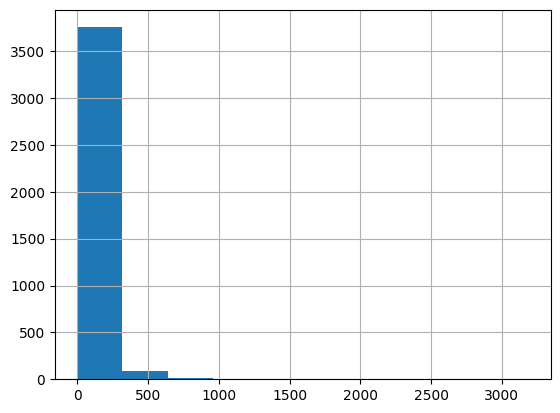

,0
count,3858.000000
mean,54.540435
std,108.506829
min,1.000000
25%,11.000000
50%,24.000000
75%,53.000000
max,3187.000000


In [89]:
comment_len = [len(x) for x in comment_in_num]
pd.Series(comment_len).hist()
plt.show()
pd.Series(comment_len).describe()

In [90]:
def pad_features(reviews_int: list[list[int]], seq_length: int) -> np.ndarray:
    #Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    features = np.zeros((len(reviews_int), seq_length), dtype = int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i,:] = np.array(new)

    return features

In [91]:
EMBEDDING_DIM = 200

In [92]:
features = pad_features(comment_in_num, EMBEDDING_DIM)

In [93]:
features

array([[    0,     0,     0, ...,    96,    97,    98],
       [    0,     0,     0, ...,   103,   127,   128],
       [    0,     0,     0, ...,   153,    14,   154],
       ...,
       [    0,     0,     0, ...,   312,  3945, 14736],
       [    0,     0,     0, ...,    81,   821,  4660],
       [    0,     0,     0, ..., 47209,     7, 19781]])

## Split the data into train and test

In [94]:
encoded_grades = df_balanced['encoded_grade'].values
encoded_grades = np.array([list(grade) for grade in encoded_grades])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(features),
    encoded_grades,
    test_size=0.20,
    random_state=42
)

In [96]:
len(X_train), len(X_test)

(3086, 772)

## Create Tensor Dataset, DataLoader

In [97]:
BATCH_SIZE = 32

In [98]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [99]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

## Model

<li>Tokenize : This is not a layer for LSTM network but a mandatory step of converting our words into tokens (integers)
<li>Embedding Layer: that converts our word tokens (integers) into embedding of specific size
<li>LSTM Layer: defined by hidden state dims and number of layers
<li>Fully Connected Layer: that maps output of LSTM layer to a desired output size
<li>Softmax Activation Layer: that turns scores into probabilities
<li>Output: Softmax output from the last timestep is considered as the final output of this network

In [100]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, n_layers,
            dropout=drop_prob, batch_first=True
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)

        out = self.activation(out)

        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        if torch.cuda.is_available():
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

In [101]:
vocab_size = len(vocabulary)+1 # +1 for the 0 padding
output_size = 3 # good, neutral, bad
hidden_dim = 256
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, EMBEDDING_DIM, hidden_dim, n_layers)

In [102]:
print(model)

SentimentLSTM(
  (embedding): Embedding(47211, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (activation): Softmax(dim=1)
)


In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [104]:
clip = 5 # gradient clipping
epochs = 25

## Train the model

In [105]:
cuda = torch.cuda.is_available()

train_losses = []
test_losses = []

if cuda:
    model.cuda()

model.train()

for epoch in tqdm.tqdm(range(epochs)):
    h = model.init_hidden(BATCH_SIZE)

    train_batch_losses = []
    for inputs, labels in train_loader:

        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        h = tuple([each.data for each in h])

        model.zero_grad()

        if cuda:
            inputs = inputs.type(torch.cuda.LongTensor)

        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        train_batch_losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    test_batch_losses = []
    with torch.no_grad():
        model.eval()
        num_correct = 0
        h = model.init_hidden(BATCH_SIZE)

        for inputs, labels in train_loader:
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            h = tuple([each.data for each in h])

            output, h = model(inputs, h)
            test_loss = criterion(output.squeeze(), labels.float())
            test_batch_losses.append(test_loss.item())

    model.train()
    train_losses.append(np.mean(train_batch_losses))
    test_losses.append(np.mean(test_batch_losses))
    tqdm.tqdm.write(f'| Train Loss: {train_losses[-1]} | Test Loss: {test_losses[-1]}')

  4%|▍         | 1/25 [00:02<01:11,  2.96s/it]

| Train Loss: 1.0895545954505603 | Test Loss: 1.0506590213626623


  8%|▊         | 2/25 [00:05<01:07,  2.93s/it]

| Train Loss: 1.0068710359434287 | Test Loss: 0.8668922061721483


 12%|█▏        | 3/25 [00:08<01:03,  2.90s/it]

| Train Loss: 0.9731658591578404 | Test Loss: 1.10989979095757


 16%|█▌        | 4/25 [00:11<01:00,  2.88s/it]

| Train Loss: 1.0776956857492526 | Test Loss: 0.9821206654111544


 20%|██        | 5/25 [00:14<00:57,  2.87s/it]

| Train Loss: 0.9250891183813413 | Test Loss: 0.7790488246828318


 24%|██▍       | 6/25 [00:17<00:54,  2.88s/it]

| Train Loss: 0.7773878381898006 | Test Loss: 0.7309177971134583


 28%|██▊       | 7/25 [00:20<00:52,  2.89s/it]

| Train Loss: 0.7166980225592852 | Test Loss: 0.6732797945539156


 32%|███▏      | 8/25 [00:23<00:49,  2.89s/it]

| Train Loss: 0.6751614641398191 | Test Loss: 0.6535815801471472


 36%|███▌      | 9/25 [00:25<00:46,  2.88s/it]

| Train Loss: 0.6598058541615804 | Test Loss: 0.6333708241581917


 40%|████      | 10/25 [00:28<00:43,  2.88s/it]

| Train Loss: 0.6374684354911248 | Test Loss: 0.6256024949252605


 44%|████▍     | 11/25 [00:31<00:40,  2.90s/it]

| Train Loss: 0.6274828097472588 | Test Loss: 0.6184298818310102


 48%|████▊     | 12/25 [00:34<00:37,  2.90s/it]

| Train Loss: 0.6220978746811548 | Test Loss: 0.6127909856537977


 52%|█████▏    | 13/25 [00:37<00:34,  2.90s/it]

| Train Loss: 0.6161877897878488 | Test Loss: 0.6072983847310146


 56%|█████▌    | 14/25 [00:40<00:31,  2.90s/it]

| Train Loss: 0.614676412815849 | Test Loss: 0.6137328445911407


 60%|██████    | 15/25 [00:43<00:29,  2.90s/it]

| Train Loss: 0.6123772772649924 | Test Loss: 0.6030430601288875


 64%|██████▍   | 16/25 [00:46<00:26,  2.92s/it]

| Train Loss: 0.6096631903201342 | Test Loss: 0.60238275056084


 68%|██████▊   | 17/25 [00:49<00:23,  2.93s/it]

| Train Loss: 0.6065598179896673 | Test Loss: 0.5985608200232188


 72%|███████▏  | 18/25 [00:52<00:20,  2.93s/it]

| Train Loss: 0.6005243255446354 | Test Loss: 0.5964388797680537


 76%|███████▌  | 19/25 [00:55<00:17,  2.92s/it]

| Train Loss: 0.6040634376307329 | Test Loss: 0.6104573092112938


 80%|████████  | 20/25 [00:58<00:14,  2.94s/it]

| Train Loss: 0.6065705828368664 | Test Loss: 0.5941175241023302


 84%|████████▍ | 21/25 [01:01<00:11,  2.94s/it]

| Train Loss: 0.5968736317008734 | Test Loss: 0.5942396881679693


 88%|████████▊ | 22/25 [01:04<00:08,  2.94s/it]

| Train Loss: 0.5961958629389604 | Test Loss: 0.5919641430179278


 92%|█████████▏| 23/25 [01:06<00:05,  2.94s/it]

| Train Loss: 0.5939756675312916 | Test Loss: 0.5894540517280499


 96%|█████████▌| 24/25 [01:09<00:02,  2.94s/it]

| Train Loss: 0.5934930462390184 | Test Loss: 0.5912748047461113


100%|██████████| 25/25 [01:12<00:00,  2.92s/it]

| Train Loss: 0.5975214050461849 | Test Loss: 0.5883531086146832


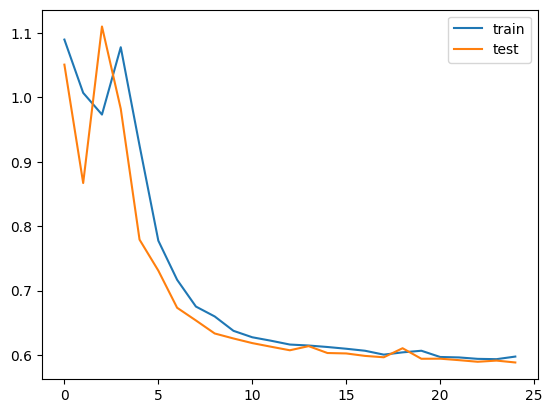

In [106]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

## Evaluate the model

In [107]:
cuda = torch.cuda.is_available()

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = model.init_hidden(BATCH_SIZE)

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

    if cuda:
        inputs = inputs.type(torch.cuda.LongTensor)
    else:
        inputs = inputs.type(torch.LongTensor)

    output, h = model(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    pred = torch.argmax(output, dim=1)  # Get the index of the max log-probability
    target = torch.argmax(labels, dim=1)
    # Compare predictions to true label
    correct_tensor = pred.eq(target)

    correct = np.squeeze(correct_tensor.cpu().numpy()) if cuda else np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)


print("Test loss: {:.3f}".format(np.mean(test_losses)))

test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 1.068
Test accuracy: 0.462


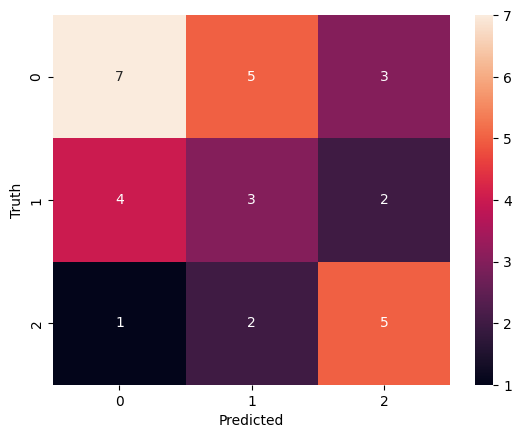

In [108]:
cm = confusion_matrix(target.cpu().numpy(), pred.cpu().numpy())
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Testing the model

In [109]:
def predict(model: SentimentLSTM, test_review: str, sequence_length: int = 200):
    cuda = torch.cuda.is_available()

    model.eval()  # Set the model to evaluation mode

    # Tokenize review
    test_words = preprocessing(test_review)
    test_ints = [word2idx[word] for word in test_words if word in word2idx]  # Only include words in vocab

    if not test_ints:
        print("No valid words found in the review.")
        return

    # Pad tokenized sequence
    features = pad_features([test_ints], sequence_length)
    feature_tensor = torch.from_numpy(features)

    if cuda:
        feature_tensor = feature_tensor.cuda()  # Move tensor to GPU if available

    # Initialize hidden state
    h = model.init_hidden(feature_tensor.size(0))  # Use the batch size of the input

    # Get the output from the model
    output, h = model(feature_tensor, h)

    # Use argmax to get the predicted class index
    pred = torch.argmax(output, dim=1).item()  # Get the index of the max log-probability

    # Print output values for debugging
    print('Output values:', output.detach().cpu().numpy())  # Detach and convert to NumPy for easier viewing

    # Map predicted class index to labels
    class_labels = {0: "bad", 1: "neutral", 2: "good"}

    # Print custom response based on prediction
    print(f"Prediction: {class_labels[pred]}")


In [110]:
predict(model, 'Ужасный фильм, мне не понравился, смотреть противно', 200)

Output values: [[9.9999952e-01 1.8456419e-07 2.2971135e-07]]
Prediction: bad


In [111]:
predict(model, 'очень хорошая книга', 200)

Output values: [[1.0795301e-09 1.2873498e-09 1.0000000e+00]]
Prediction: good


In [112]:
predict(model, 'книга отстой можно в мусорку', 200)

Output values: [[9.9981755e-01 1.2998508e-04 5.2386360e-05]]
Prediction: bad


In [113]:
predict(model, 'книга отстой? никогда не читайте', 200)

Output values: [[1.0000000e+00 1.3589714e-08 2.7626260e-08]]
Prediction: bad


In [114]:
predict(model, 'книга супер', 200)

Output values: [[9.8770681e-09 4.4742205e-09 1.0000000e+00]]
Prediction: good


In [115]:
predict(model, 'гавно фильм', 200)

Output values: [[9.9950755e-01 1.9224091e-04 3.0029251e-04]]
Prediction: bad


In [116]:
predict(model, 'очень хороший фильм', 200)

Output values: [[0.01537006 0.04762119 0.93700874]]
Prediction: good
